In [4]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt
import time


seed = 2  # parameter to create file name (it starts with this integer number)

# relevant values of seed:
# 1 - initial few investigations
# 2 - began experimenting with reducing g

[-0.05 -0.15 -0.25 -0.35 -0.45 -0.55 -0.65 -0.75 -0.85 -0.95 -1.05 -1.15
 -1.25 -1.35 -1.45 -1.55 -1.65 -1.75 -1.85 -1.95 -2.05 -2.15 -2.25 -2.35
 -2.45 -2.55 -2.65 -2.75 -2.85 -2.95 -3.05 -3.15 -3.25 -3.35 -3.45 -3.55
 -3.65 -3.75 -3.85 -3.95 -4.05 -4.15 -4.25 -4.35 -4.45 -4.55 -4.65 -4.75
 -4.85 -4.95]


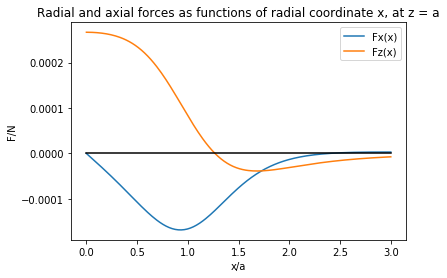

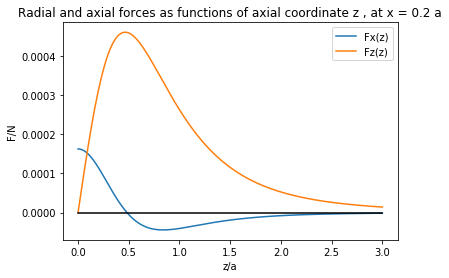

In [7]:
# physical parameters

reduce_g = 0.2 # reduce g in order to see radial oscillations in a shorter tube with shorter time !!!
g = reduce_g * 9.81   # gravity acceleration (N/kg)

a = 0.05   # radius of tube (m)
H = 5  # length of tube (m)
h = 0.01   # thickness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)



# simulation parameters
t_max = 2.5
max_iter = 7500   # total number of iterations in time
dt = t_max/max_iter

init_height = -0.3*H # setting the initial condition z[0]
init_displ = 0.2*a  # setting the initial condition x[0]

N = 50  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
Z_ring = -(np.arange(N)+1/2) * dH   # array that stores effective positions of rings (midpoints in z)
print(Z_ring)




def emf(x,z,vz):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    v = z/a
    u = x/a
    integral =  s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 - 2*u*cos(phi) + v**2)**(5/2), 0, 2*pi )
    integral = integral[0]
    integral *= - 3 * mu/4/pi * m * vz / a**2
    return integral


def force_z(x,z,J):
    """Magnetic force of an elemental ring in z-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= + 3 * mu/4/pi * m / a**2 * J
    return integral
    
def force_x(x,z,J):
    """Magnetic force of an elemental ring in x-direction, argument z interpreted as z(magnet) - z_ring"""
    u = x/a
    v = z/a
    integral = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral = integral[0]
    integral *= +  mu/4/pi * m / a**2 * J
    return integral


# investigate the spatial dependence of forces

gridlength = 200
Fx_x, Fx_z, Fz_x, Fz_z = np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength)
J = 1
x_fix = 0.2*a
z_fix = 1*a

X = np.linspace(0, 3*a, gridlength)
Z = np.linspace(0,3*a,gridlength)

for i in range(gridlength):
    Fx_x[i] = force_x(X[i], z_fix, J)
    Fx_z[i] = force_x(x_fix, Z[i], J)
    Fz_x[i] = force_z(X[i], z_fix, J)
    Fz_z[i] = force_z(x_fix, Z[i], J)

plt.plot(X/a, Fx_x, label="Fx(x)")
plt.plot(X/a, Fz_x, label="Fz(x)")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.title("Radial and axial forces as functions of radial coordinate x, at z = a")
plt.xlabel('x/a')
plt.ylabel('F/N')
plt.show()

plt.plot(Z/a, Fx_z, label="Fx(z)")
plt.plot(Z/a, Fz_z, label="Fz(z)")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.title("Radial and axial forces as functions of axial coordinate z , at x = 0.2 a")
plt.xlabel('z/a')
plt.ylabel('F/N')
plt.show()



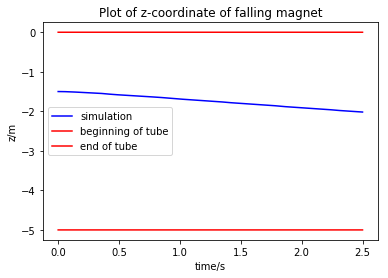

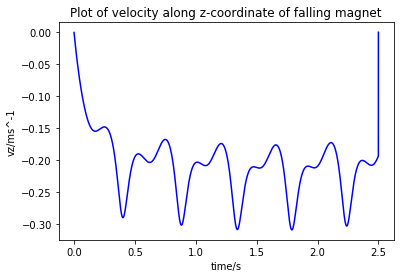

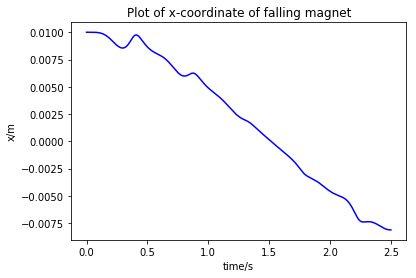

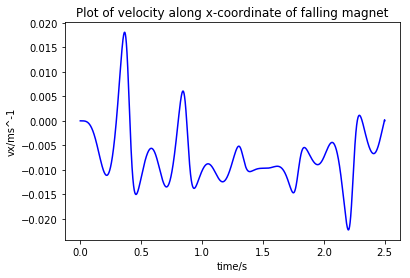

final coordinate of magnet, in cm: -201.85
and in case of free fall, in cm:   -763.12


simulation took 156.72 s


In [8]:
# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along axes as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

J = np.zeros((max_iter,N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter,N)) # array that stores lateral forces (in Newtons) in all rings as time progresses
Fz = np.zeros((max_iter,N)) # array that stores vertical forces (in Newtons) in all rings as time progresses



# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

J[0,:] = 0
J[1,:] = 1/R * emf(x[1],z[1],vz[0]+1/2*dt*az[0])  # use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]



# solve using an improved finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], J[i,n])
        
    ax[i] = 1/M * sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * sum(Fz[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )

sim_end = time.time()    
    
    
    
plt.plot(T,z,'b',label='simulation')
#plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
plt.plot(T, 0*np.ones(max_iter),'r', label='beginning of tube')
plt.plot(T, -H*np.ones(max_iter),'r', label='end of tube')
plt.legend()
plt.xlabel('time/s')
plt.ylabel('z/m')
plt.title('Plot of z-coordinate of falling magnet')
plt.show()

plt.plot(T,vz,'b')
plt.xlabel('time/s')
plt.ylabel('vz/ms^-1')
plt.title('Plot of velocity along z-coordinate of falling magnet')
plt.show()

plt.plot(T,x,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('x/m')
plt.title('Plot of x-coordinate of falling magnet')
plt.show()

plt.plot(T,vx,'b')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.show()



folder = 'python_arrays'
np.savetxt('{}/{}_x_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), x)
np.savetxt('{}/{}_vx_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vx)
np.savetxt('{}/{}_z_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), z)
np.savetxt('{}/{}_vz_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), vz)
np.savetxt('{}/{}_J_N{}_iter{}_t{}'.format(folder, seed, N, max_iter, t_max), J)


ref = -65.1665
print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
#print("value from ref. simulation, in cm:", ref)
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
#print("percentage error of reduction in free-fall distance from reference:  ",(z[-1]*100-ref)/((init_height-1/2*g*T[-1]**2)*100 - ref) * 100,"%")
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


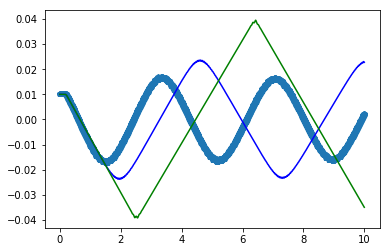

In [15]:
# examination of motion as it changes with different number N of partitions of tube 

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

x_N100 = np.loadtxt('python_arrays/1_x_N100_iter1500_t10')
x_N300 = np.loadtxt('python_arrays/1_x_N300_iter1500_t10')
x_N1000 = np.loadtxt('python_arrays/1_x_N1000_iter1500_t10')

plt.plot(T,x_N100, 'p')
plt.plot(T,x_N300, 'b')
plt.plot(T,x_N1000, 'g')
plt.show()


In [ ]:
"""

Notes on graphs:

e.g. N = 50
- this is manifested in number of "ripples" in vz graph, as the magnitude of force slightly varies as magnet falls w.r.t. centres of rings (current density as function of z is a delta comb with N spikes)
- these ripples are modulated by a wave with twice the frequency of radial oscillations - as for the evaluation of z-forces, it is the same whether the magnet is on +ve side with +/- velocity or on -ve side with -/+ velocity
- why is there such a huge noise in vx? i.e. what is the source of small ripples in x data?

- these concepts best seen in file "tube_off_axis-Copy6.ipynb"

"""